This notebook implements the Lattice Boltzmann Method (LBM) for fluid flow passing a cylindrical obstacle.

# LBM Cookbook

1. Define some constants such as the Reynolds number (Re), inital horizontal inflow velocity ($u_0$) and number of simulation time steps. 

2. Define the size fo the domain and use that to define the central indices of the cylinder. Use the size of the doamin to obtain a mesh and create a boolean mask that models the cylindrical obstacle.

3. Define the relative directions of the discrete lattice velocities, call this for lattice_config. This should be an array that consist of (-1,0,1). Note the order of the coordinates, it should reflect the D2Q9 diagram in the report.

4. Based on the lattice configurations, define two 1D arrays with 9 elements each with indices that correspond to the discrete lattice velocities and the corresponding reflected version. Note the order of the indices, also the center lattice should not be reflected. The purporse is to handle how the local particle should be updated after collision.

5. Define the lattice weights as a 1D array, the numerical values should follow the ones defined in the report. Note that the order must be consistent with the array in step 3.

6. Define a set of 1D arrays with three components that contains the indices for the velocity components right, up, left, down, pure horizontal, and pure vertical. These indices will then be used to update the previous velocities in the specified flow direction. The arrays should follow some specific arrangements according to the D2Q9 scheme. 

7. Use the expression for Reynolds number and the predefined numerical values for Re, L and u0 to determine the the dynamic viscosity $\mu$. 

8. Compute the unitless relaxation time using the formula from the report by setting $\rho = \Delta t = 1$.

9. Initialize the horizontal flow velocity to $u_0$ with no vertical component.


10. Define a function that takes the initial velocity vector field as well as a homogeneous density scalar field and returns the equilibrium lattice velocities at each point. This array should have dimension (Nx, Ny, 9).

11. Define a function that takes the equilibrium lattice velocities, lattice configuration and the density to compute the macroscopic velocity field. The result should be an array with dimension (Nx, Ny, 2).

12. Define a function that takes care of the outflow boudnary condition. This can be done by setting the outflow velocity at the last column equal to the velocity at the second to last column.


13. Define a function that takes care of the inflow boundary condition for the velocity. This is done by copying the values of the background flow at the first column excluding the two corners which must be modeled with another rule.

14. Handle the density at the inflow, this can be done by using: 
\begin{equation}
    \rho = \frac{c}{c - u_x}\left[
    f_0 + f_2 + f_4 + 2(f_3 + f_6 + f_7)
    \right]
\end{equation}
with the unitless velocity $c=1$.


15. Define a function that handles the BGK collision. 

16. Handle the inflow lattice velocities.

17. Define a function that handles the bounce-back boundary condition.

18. Perform the streaming on the lattice velocities after collision.

19. Putting everything together in a function that updates the lattice velocities.

In [2]:
!pip install cmasher -q
import matplotlib.pyplot as plt
import cmasher as cmr
from tqdm import tqdm
import numpy as np 
from numba import njit
from matplotlib.animation import *

plt.rcParams["figure.figsize"] = [15, 7]
plt.rcParams["figure.dpi"] = 150

## Initialization

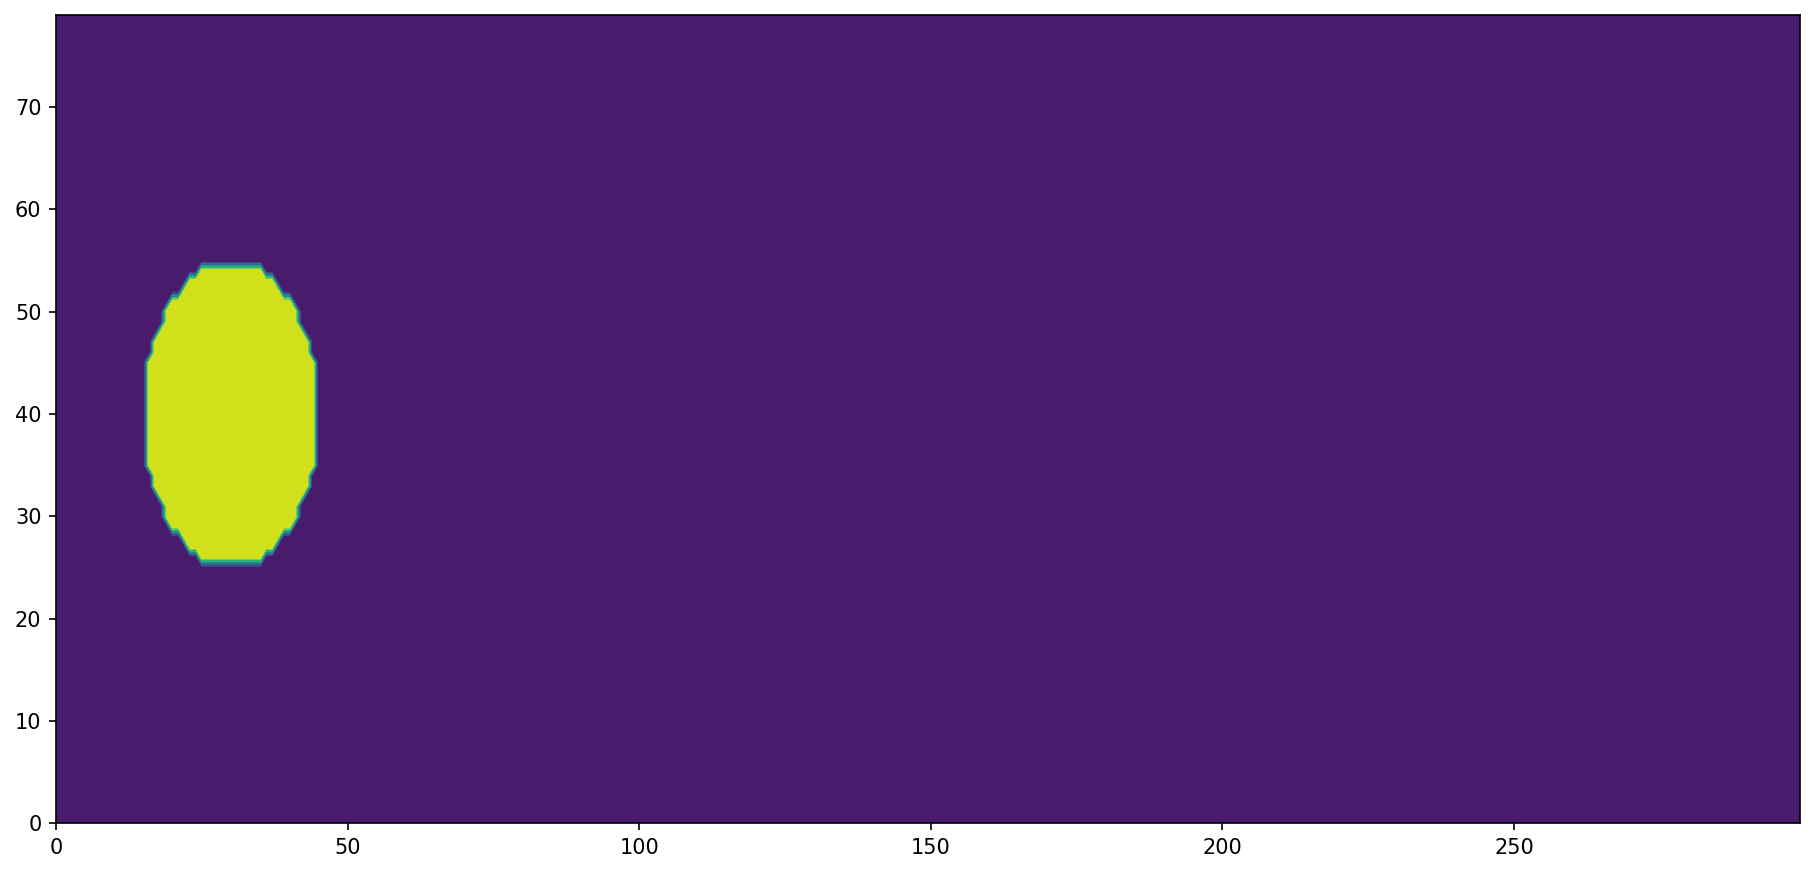

In [83]:
## Unitless physical constants

Re = 80 # Reynold's number
mass_density = 1 # Unitless mass density
inflow_speed = 0.05 # Initial horizontal inflow < 1, this is assumed to be constant throughout the simulation
dt = 1 # Change in time
simulation_time_steps = 10000 # Total number of steps of the simulation
record_steps = 100 # Record every 100 simulation steps 
Nx, Ny = (300, 80) # Size of the domain
R = Nx // 20 # Radius of the cylinder, this value will be used as the characteristic length
mu = mass_density * inflow_speed * R / Re # Uniteless dynamic viscousity


# The D2Q9 lattice configuration
"""
 6  2  5
  \ | /
3 - 0 - 1 
  / | \
 7  4  8
"""

lattice_config = np.array([
    [0, 1, 0, -1, 0, 1, -1, -1, 1],
    [0, 0, 1, 0, -1, 1, 1, -1, -1],
])

lattice_indices = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8])
reflected_lattice_indices = np.array([0, 3, 4, 1, 2, 7, 8, 5, 6])
lattice_weights = np.array([
    4/9, # center
    1/9, 1/9, 1/9, 1/9, # sides
    1/36, 1/36, 1/36, 1/36, # diagonals
])

# These arrays will determine the flow directions
east_indices = np.array([5, 1, 8])
north_indices = np.array([6, 2, 5])
west_indices = np.array([7, 3, 6])
south_indices = np.array([7, 4, 8])
vertical_indices = np.array([2, 0, 4])
horizontal_indices = np.array([3, 0, 1])


center_of_mass = (Nx//10, Ny//2)
x, y = np.arange(Nx), np.arange(Ny)
X, Y = np.meshgrid(x, y, indexing="ij")
# This is a boolean array with True when its considered to be an obstacle and False when it is fluid
cylinder = np.sqrt((X - center_of_mass[0])**2 + (Y - center_of_mass[1])**2) < R

# Initializing the velocity field such that 
# there is a constant horizontal flow form left to right 
velocity_field = np.zeros([Nx, Ny, 2]) 
velocity_field[..., 0] = inflow_speed
background_flow = velocity_field

plt.contourf(X, Y, cylinder)
plt.show()

In [84]:
def rho(lattice_matrix): # (Nx, Ny, 9) -> (Nx, Ny, 1)
    return lattice_matrix.sum(-1, keepdims=True)

def f_eq(velocity_field, lattice_config, density_field): # (Nx, Ny, 2), (2, 9), (Nx, Ny, 1) -> (Nx, Ny, 9)
    projected_velocity_field = velocity_field @ lattice_config
    speed_field = np.linalg.norm(velocity_field, ord=2, axis=-1, keepdims=True)
    equilibrium_lattice_velocities = density_field * lattice_weights[None, None] * (
        1 + 3 * projected_velocity_field + 9/2 * projected_velocity_field**2 - 3/2 * speed_field**2
    ) 
    return equilibrium_lattice_velocities

initial_density = np.ones([Nx, Ny, 1])
equilibrium_lattice_velocities = f_eq(velocity_field, lattice_config, initial_density)
density = rho(equilibrium_lattice_velocities)

equilibrium_lattice_velocities.shape, density.shape

((300, 80, 9), (300, 80, 1))

In [144]:
# Using the equilibrium lattice velocities to compute the velocity field
def get_velocity_field(equilibirum_lattice_velocities, lattice_config, density): # (Nx, Ny, 9) x (2, 9) / (Nx, Ny, 1) -> (Nx, Ny, 2)
    return equilibrium_lattice_velocities @ lattice_config.T / density

velocity_field = get_velocity_field(equilibrium_lattice_velocities, lattice_config, density)
velocity_field.shape

(300, 80, 2)

In [148]:
# Using the equilibrim lattice velocities to compute the outflow velocity bounary condition
def outflow_velocity(equilibrium_lattice_velocities):
    equilibrium_lattice_velocities[-1, :, west_indices] = equilibrium_lattice_velocities[-2, :, west_indices]
    return equilibrium_lattice_velocities # equilibrium lattice velocities but the velocity boundary condition is considered

equilibrium_lattice_velocities = outflow_velocity(equilibrium_lattice_velocities)
equilibrium_lattice_velocities.shape

(300, 80, 9)

In [147]:
def inflow_velocity(velocity_field, background_flow): 
    velocity_field[0, 1:-1] = background_flow[0, 1:-1]
    return velocity_field

def inflow_density(equilibrium_lattice_velocities, velocity_field, density):
    vertical_density = rho(equilibrium_lattice_velocities[0, :, vertical_indices].T)
    west_density = rho(equilibrium_lattice_velocities[0, :, west_indices].T)
    # Implementing equation (16) from the report with c = 1
    # The indices are choosen in a way that it updates the horizontal component of the first column.
    density[0] = (vertical_density + 2 * west_density) / (1 - velocity_field[0, :, 0:1])
    return density

velocity_field = inflow_velocity(velocity_field, background_flow) 
density = inflow_density(equilibrium_lattice_velocities, velocity_field, density)

velocity_field.shape, density.shape

((300, 80, 2), (300, 80, 1))

In [99]:
def BGK(lattice_velocities, equilibrium_lattice_velocities):
    relaxation_time = 1 / (3 * mu + 0.5)
    post_collision_lattice_velocities = lattice_velocities \
    - (lattice_velocities - equilibrium_lattice_velocities) / relaxation_time
    return post_collision_lattice_velocities

lattice_velocities = equilibrium_lattice_velocities
equilibrium_lattice_velocities = f_eq(velocity_field, lattice_config, density)

post_collision_lattice_velocities = BGK(lattice_velocities, equilibrium_lattice_velocities)
post_collision_lattice_velocities.shape

(300, 80, 9)

In [112]:
# This functon ensures that there is always a flow of fluid 
# at the very left boundary that moves to the right. 
# The values that is assigned is the equilibrium lattice velocities.
# Note that this must be done AFTER the velocity field is updated, 
# otherwise we would have more fluid than allowed in the domain.
def lattice_inflow_velocity(lattice_velocities, equilibrium_lattice_velocities):
    lattice_velocities[0, :, east_indices] = equilibrium_lattice_velocities[0, :, east_indices]
    return lattice_velocities

lattice_velocities = lattice_inflow_velocity(lattice_velocities, equilibrium_lattice_velocities)
lattice_velocities.shape

(300, 80, 9)

In [142]:
def bounce_back_boundary_condition(
    lattice_velocities, 
    post_collision_lattice_velocities, 
    obstacle, lattice_indices, 
    reflected_lattice_indices
):
    for i, j in zip(lattice_indices, reflected_lattice_indices):
        # Assigning the new lattice velocities that correspond to indices 'i' with 
        # the reflected lattice velocities that correspond to indices 'j'. 
        # The values are then conditioned by the obstacle (boolean) mask.
        post_collision_lattice_velocities[obstacle, i] = lattice_velocities[obstacle, j]
        
    return post_collision_lattice_velocities

post_collision_lattice_velocities = bounce_back_boundary_condition(
    lattice_velocities, 
    post_collision_lattice_velocities, 
    cylinder, 
    lattice_indices, 
    reflected_lattice_indices
)

post_collision_lattice_velocities.shape

(300, 80, 9)

In [161]:
def streaming(post_collision_lattice_velocities, lattice_config):
    streamed_lattice_velocities = post_collision_lattice_velocities
    for i, direction in enumerate(lattice_config.T):   
        horizontal_index, vertical_index = direction
        # Shifting the post collision lattice velocities in the horizontal direction (axis=0) 
        # according to the relative indices defined in the lattice_config array 
        # -1 = left, 0 = stationary, 1 = right
        horizontal_shift = np.roll(post_collision_lattice_velocities[..., i], horizontal_index, axis=0)

        # Simultaneously shifting in the vertical direction (axis=1).
        # Storing the result in a new lattice configuration that have been 'streamed'.
        # This is then repeated for every i:th lattice in the D2Q9 lattice configuration.
        streamed_lattice_velocities[..., i] = np.roll(horizontal_shift, vertical_index, axis=1)
        
    return streamed_lattice_velocities
    
lattice_velocities = streaming(post_collision_lattice_velocities, lattice_config) # Updated lattice velocities
lattice_velocities.shape

(300, 80, 9)

In [160]:
initial_density = np.ones([Nx, Ny, 1])
initial_lattice_velocities = f_eq(background_flow, lattice_config, initial_density)

velocity_field = np.zeros([Nx, Ny, 2]) 
velocity_field[..., 0] = inflow_speed
background_flow = velocity_field

def update_lattice_velocities(lattice_velocities, velocity_field):
    # Compute the density
    density = rho(lattice_velocities)
    
    # Handling the outflow boundary condition
    lattice_velocities = outflow_velocity(lattice_velocities)
    
    # Handing the inflow boundary condition
    inflow_velocity_field = inflow_velocity(velocity_field, background_flow)
    density = inflow_density(lattice_velocities, inflow_velocity_field, density)
    
    # Computing the equilibrium lattice velocities 
    equilibrium_lattice_velocities = f_eq(inflow_velocity_field, lattice_config, density)
    
    # Making sure that fluid continously enters the domain
    lattice_velocities = lattice_inflow_velocity(lattice_velocities, equilibrium_lattice_velocities)
    
    # Handling the collisions
    # Collision between particles
    post_collision_lattice_velocities = BGK(lattice_velocities, equilibrium_lattice_velocities) 
    # Collision with obstacle and top/bottom side of domain
    post_collision_lattice_velocities = bounce_back_boundary_condition(
        lattice_velocities, # using the latest updated lattice velocities
        post_collision_lattice_velocities, # handling the collision with obstacle after collision between particles
        cylinder, # boolean mask determined by type of obstacle
        lattice_indices, 
        reflected_lattice_indices # determined by the lattice configuration
    )
    
    # Streaming
    updated_lattice_velocities = streaming(post_collision_lattice_velocities, lattice_config)

    return updated_lattice_velocities

update_lattice_velocities(initial_lattice_velocities, velocity_field).shape

(300, 80, 9)